<a href="https://colab.research.google.com/github/apanariello4/colab-notebooks/blob/main/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import utils

transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST('/tmp/data', train=True, download=True, 
                               transform=transforms)

test_dataset = datasets.MNIST('./data', train=False, download=True,
                              transform=transforms)

In [198]:
BATCH_SIZE      = 64        
N_EPOCHS        = 20       
INPUT_DIM       = 28 * 28   # MNIST img size
HIDDEN_DIM      = 256       
LATENT_DIM      = 20        
lr              = 1e-3
VARIANCE        = 0.01 

In [199]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [200]:
class Encoder(nn.Module):
  
  def __init__(self, input_dim: int, hidden_dim: int, code_dim: int):
    super(Encoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, code_dim),
    )

  def forward(self, x: torch.Tensor):
    return self.encoder(x)

In [201]:
class Decoder(nn.Module):
  
  def __init__(self, output_dim: int, hidden_dim: int, code_dim: int):
    super(Decoder, self).__init__()

    self.decoder = nn.Sequential(
        nn.Linear(code_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )

  def forward(self, x: torch.Tensor):
    return self.decoder(x)

In [202]:
class DAE(nn.Module):
  
  def __init__(self, enc: Encoder, dec: Decoder):
    super(DAE, self).__init__()
    self.enc = enc
    self.dec = dec

  def forward(self, x):
    x = self.enc(x)
    x = self.dec(x)

    return x

In [203]:
def add_gaussian_noise(img: torch.Tensor, variance: float = VARIANCE) -> torch.Tensor:
  return img + (variance**0.5)*torch.randn_like(img)

In [204]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder   = Encoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, code_dim=LATENT_DIM)
decoder   = Decoder(output_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, code_dim=LATENT_DIM)
model     = DAE(encoder, decoder).to(device) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

cuda


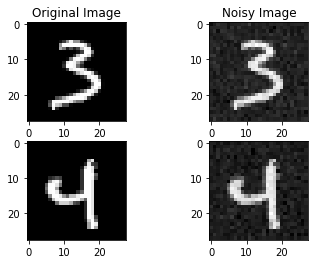

In [205]:
# Show noisy images
dataiter = iter(train_iterator)
images, _ = dataiter.next()

images = images[1:3,:,:,:]

fig, ax = plt.subplots(2,2)
ax[0,0].set_title("Original Image")
ax[0,1].set_title("Noisy Image")

for i, img in enumerate(images):
  ax[i,0].imshow(img.squeeze(), cmap='gray')

  noisy = add_gaussian_noise(img)

  ax[i,1].imshow(noisy.squeeze(), cmap='gray')
  

In [206]:
l=len(train_iterator)
losslist=list()
epochloss=0
running_loss=0

for e in range(N_EPOCHS):
    for data in train_iterator:
        img, _ = data
        img = img.view(-1, INPUT_DIM).to(device)
        
        # Add gaussian noise mean=1, var=0.1
        noisy_img = add_gaussian_noise(img).to(device)

        # ===================forward=====================
        output = model(noisy_img)
        loss = criterion(output, img)

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ===================log========================
        running_loss+=loss.item()
        epochloss+=loss.item()
    
    #-----------------Log-------------------------------
    losslist.append(running_loss/l)
    running_loss=0
    print("======> epoch: {}/{}, Loss:{}".format(e,N_EPOCHS,loss.item()))

======> epoch: 0/20, Loss:0.06984355300664902
======> epoch: 1/20, Loss:0.07587455213069916
======> epoch: 2/20, Loss:0.05721799656748772
======> epoch: 3/20, Loss:0.059557635337114334
======> epoch: 4/20, Loss:0.06430938094854355
======> epoch: 5/20, Loss:0.053758688271045685
======> epoch: 6/20, Loss:0.06446721404790878
======> epoch: 7/20, Loss:0.05324189364910126
======> epoch: 8/20, Loss:0.05052812770009041
======> epoch: 9/20, Loss:0.0520518459379673
======> epoch: 10/20, Loss:0.04668348655104637
======> epoch: 11/20, Loss:0.053703200072050095
======> epoch: 12/20, Loss:0.042818713933229446
======> epoch: 13/20, Loss:0.04644020274281502
======> epoch: 14/20, Loss:0.04666832461953163
======> epoch: 15/20, Loss:0.04574984684586525
======> epoch: 16/20, Loss:0.045384250581264496
======> epoch: 17/20, Loss:0.04273485392332077
======> epoch: 18/20, Loss:0.043291255831718445
======> epoch: 19/20, Loss:0.0431252084672451


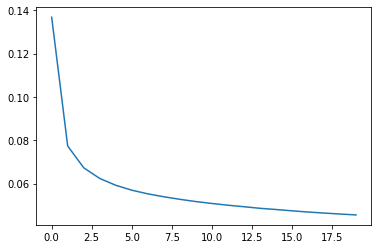

In [207]:
plt.plot(range(len(losslist)),losslist)

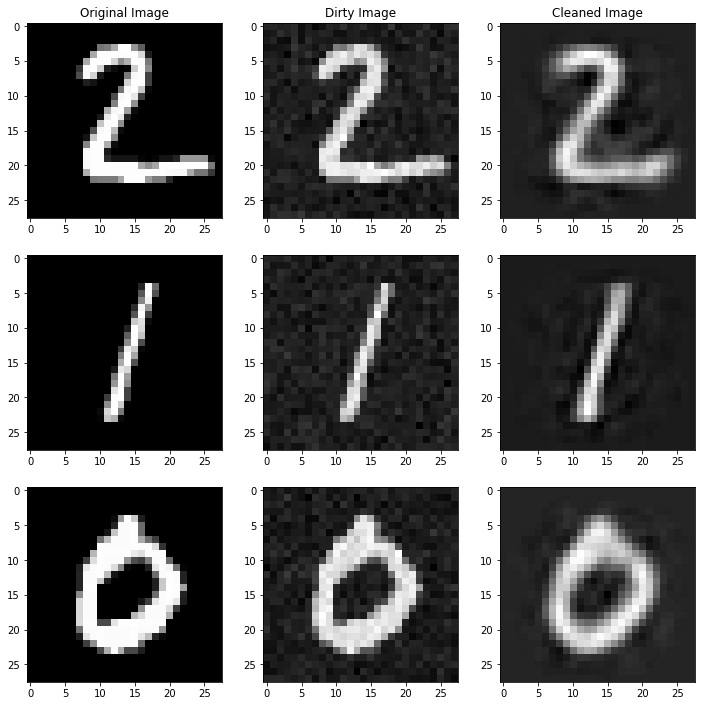

In [208]:
#Show results on test set
dataiter = iter(test_iterator)
images, _ = dataiter.next()

images = images[1:4,:,:,:]

fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax[0,0].set_title("Original Image")
ax[0,1].set_title("Dirty Image")
ax[0,2].set_title("Cleaned Image")
fig.tight_layout(h_pad=1)

with torch.no_grad():
  for i, img in enumerate(images):
    ax[i,0].imshow(img.squeeze(), cmap='gray')

    noisy = add_gaussian_noise(img)

    ax[i,1].imshow(noisy.squeeze(), cmap='gray')

    reconstructed = model(noisy.view(noisy.size(0), -1).to(device))

    ax[i,2].imshow(reconstructed.to('cpu').view(28,28), cmap='gray')